# Personalised Praise: Retention on Spanish Wikipedia

This notebook examines whether Mentorship and Personalised Praise impacts newcomer retention on Spanish Wikipedia. Since we defined our window of opportunity for praise to be thirty days, we have also shifted retention to have the same thirty-day window.

In this notebook, we examine this two ways. First, we compare the control group (no mentorship) against Mentorship with Personalised Praise for the period after full deployment of the feature. Second, we do a Difference-in-Differences analysis of Mentorship with and without Personalised Praise, by comparing with the control group pre/post deployment.

## Findings

We find that Mentorship with Personalised Praise does not lead to any change in retention.

In [1]:
library(tidyverse)
library(broom)

# library(brms) # install.packages("brms")
# library(loo) # install.packages("loo")
# library(rstanarm) # install.packages("rstanarm")

library(lubridate)

library(lme4)

library(here)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

Warning message:
“package ‘RhpcBLASctl’ was built under R version 4.2.3”


# Configuration variables

In [3]:
## Wide dataset with editing data, used specifically for this type of analysis
editing_dataset_filename <- here('datasets', 'personalised_praise_eswiki_editing_data.tsv')

## Column types in the editing dataset
## wiki, experiment group, and platform are all factors,
## registration timestamp is treated as character (parsed by lubridate later),
## the other columns are integers
editing_dataset_column_types <- 'ficffiiiiiiiii'

# Data import and setup

In [5]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename, dataset_column_types) {
    read_tsv(
        dataset_filename,
        col_types = dataset_column_types) %>%
    mutate(
        # Parse the timestamp
        user_registration_ts = ymd_hms(user_registration),
        # Convert multiple variables to factors or boolean
        platform_name = factor(ifelse(platform == 'desktop', 'Desktop', 'Mobile web')),
        has_mentor = factor(ifelse(mentor_enabled == 1, 'Yes', 'No')),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_30d = num_article_edits_30d + num_other_edits_30d,
        num_total_edits = num_total_edits_24hrs + num_total_edits_30d,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_30d,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_30d,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_30d = num_article_reverts_30d + num_other_reverts_30d,
        num_total_reverts = num_reverts_24hrs + num_reverts_30d,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_30d > 0),
        is_retained_other = is_activated_other & (num_other_edits_30d > 0),
        is_retained = is_activated & ((num_article_edits_30d + num_other_edits_30d) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_30d - num_article_reverts_30d) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_30d - num_other_reverts_30d) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_30d + num_other_edits_30d -
              num_article_reverts_30d - num_other_reverts_30d) > 0)
    ) 
}

In [6]:
editing_data <- read_user_dataset(editing_dataset_filename, editing_dataset_column_types)

In [7]:
nrow(editing_data)

[1] 113482

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [9]:
editing_data %>%
    group_by(wiki_db, platform_name, exp_group, has_mentor) %>%
    summarize(n = n())

`summarise()` has grouped output by 'wiki_db', 'platform_name', 'exp_group'.
You can override using the `.groups` argument.


wiki_db platform_name exp_group           has_mentor n    
1 eswiki  Desktop       control             No         11355
2 eswiki  Desktop       control             Yes         2022
3 eswiki  Desktop       personalised_praise No         26764
4 eswiki  Desktop       personalised_praise Yes        23134
5 eswiki  Mobile web    control             No          9437
6 eswiki  Mobile web    control             Yes         1739
7 eswiki  Mobile web    personalised_praise No         20812
8 eswiki  Mobile web    personalised_praise Yes        18219

# Retention Proportions

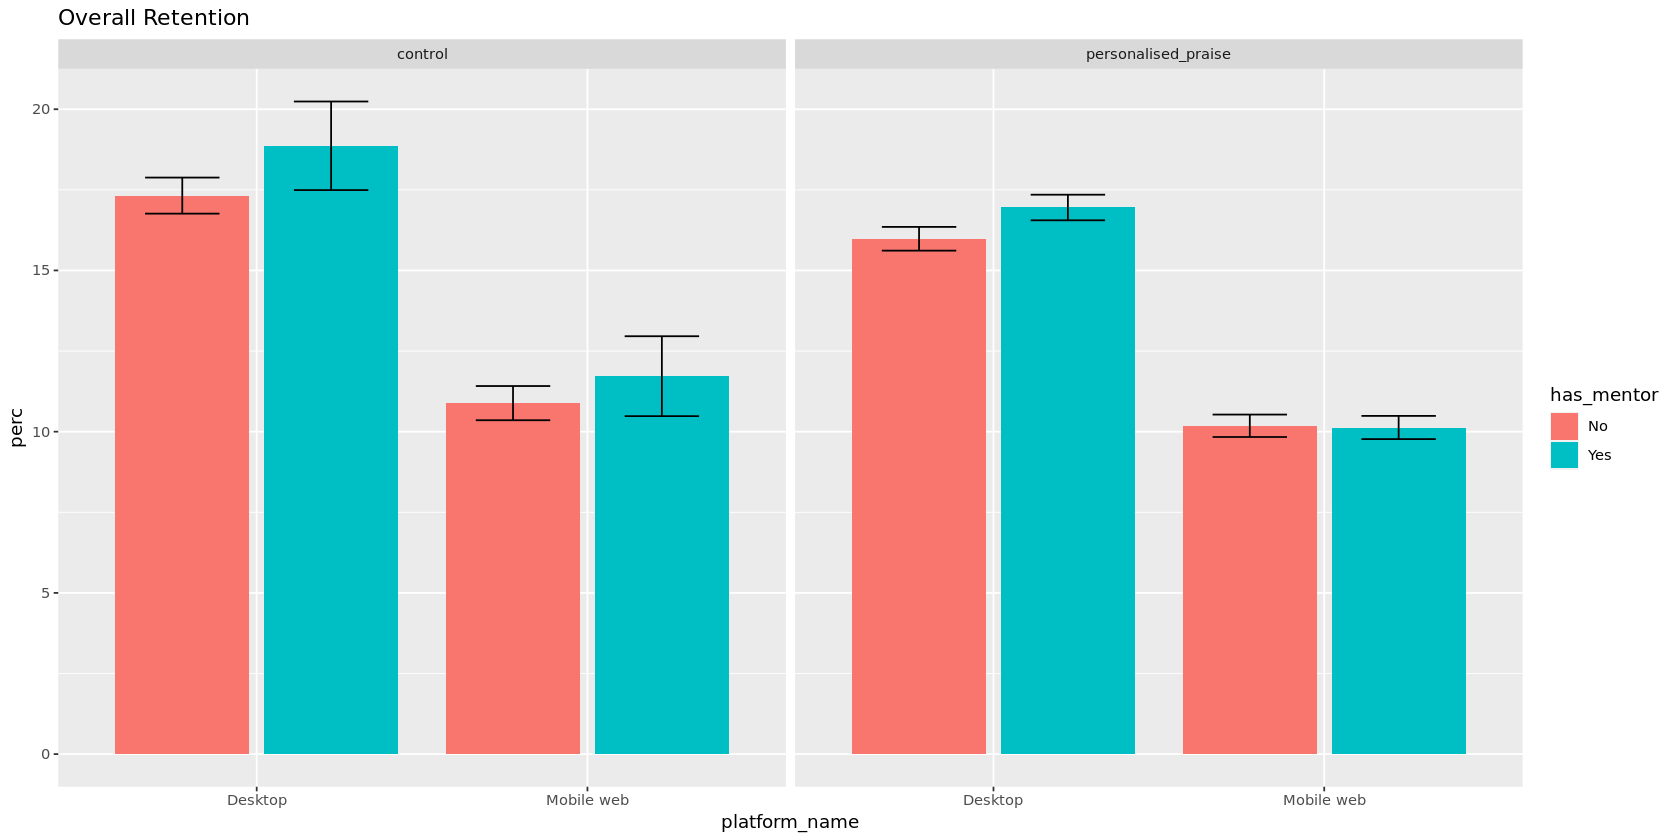

In [10]:
editing_data %>%
    filter(is_activated == TRUE) |>
    group_by(platform_name, exp_group, has_mentor, is_retained) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_retained == TRUE) %>%
    ggplot(aes(x = platform_name, y = perc, fill = has_mentor)) +
        labs(title = 'Overall Retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        facet_grid(. ~ exp_group)

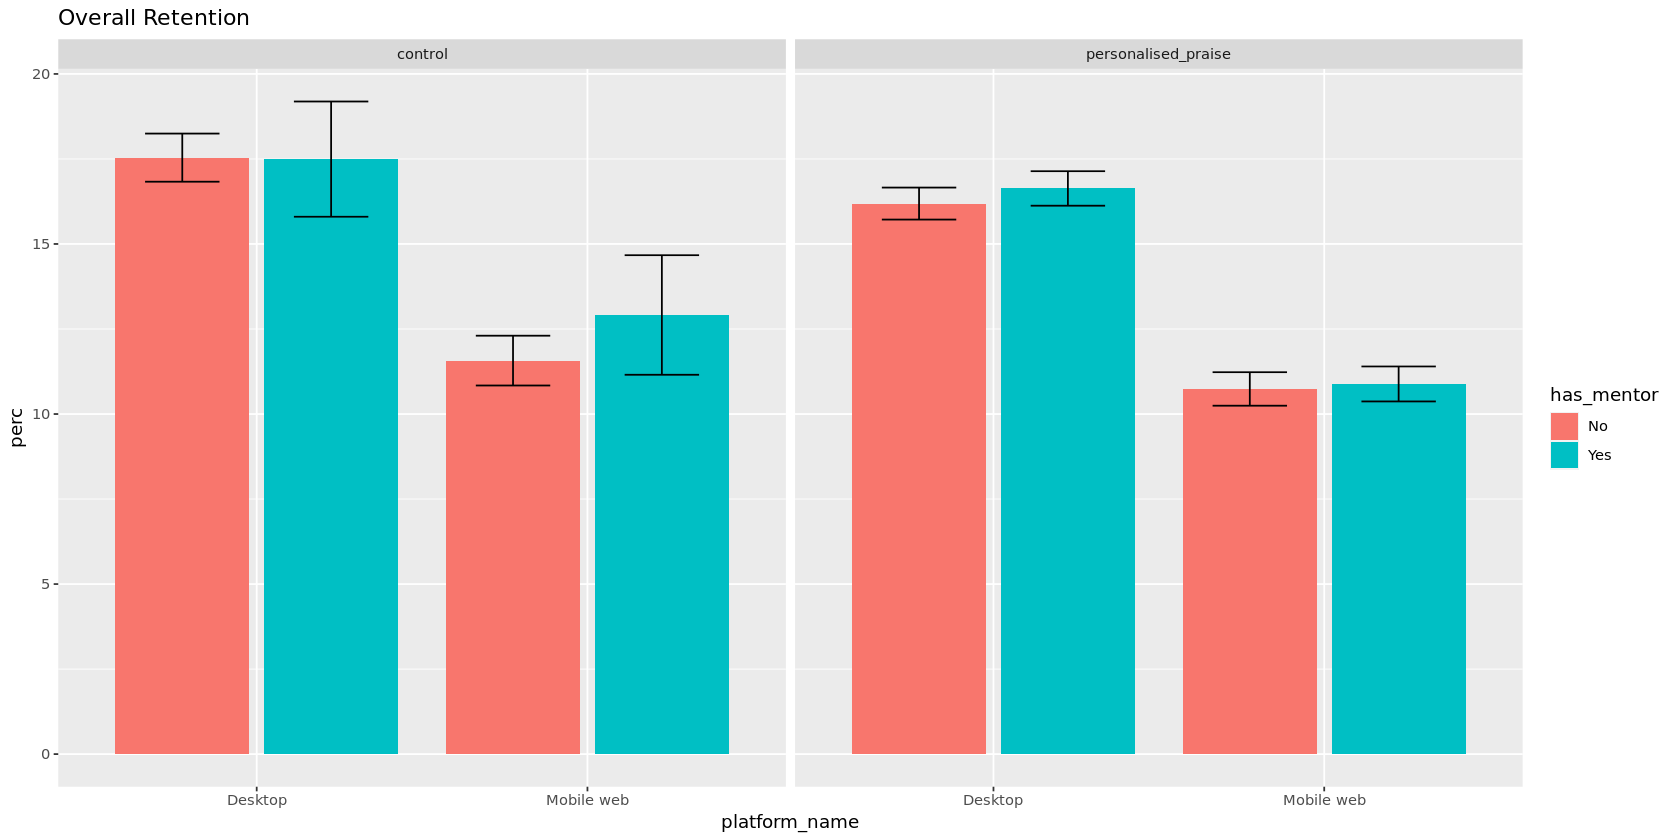

In [12]:
editing_data %>%
    filter(is_const_activated_article == TRUE) |>
    group_by(platform_name, exp_group, has_mentor, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = platform_name, y = perc, fill = has_mentor)) +
        labs(title = 'Overall Retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        facet_grid(. ~ exp_group)

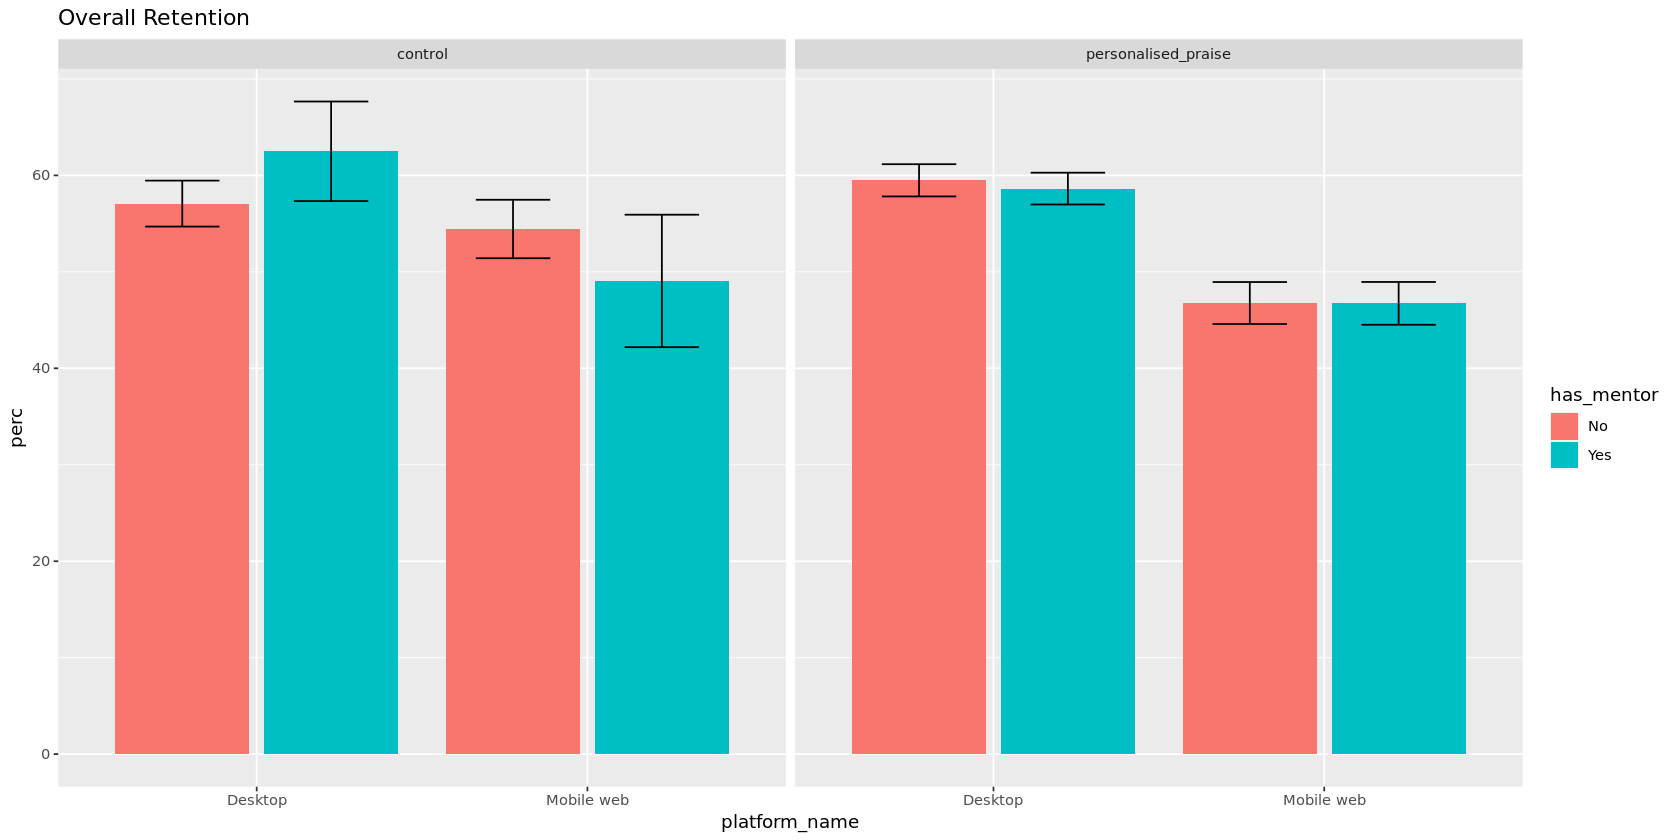

In [14]:
editing_data %>%
    filter(
        (is_const_activated_article == TRUE) &
        (num_total_edits > 7)
    ) |>
    group_by(platform_name, exp_group, has_mentor, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = platform_name, y = perc, fill = has_mentor)) +
        labs(title = 'Overall Retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        facet_grid(. ~ exp_group)

It's not obvious that mentorship has a positive effect on retention, nor that having Personalised Praise increases retention. Once we run the regression models, we'll know more.

# Regression models

We start by investigating overall retention for the Personalised Praise period. In this case, we define the period as after *full* deployment, meaning we filter out all registrations prior to 2023-05-25.

## Overall retention

In [44]:
blas_set_num_threads(16)
overall.retention.model.1 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    glm(
        formula = is_retained ~ platform + has_mentor + is_activated + log_num_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [45]:
summary(overall.retention.model.1)


Call:
glm(formula = is_retained ~ platform + has_mentor + is_activated + 
    log_num_edits_24hrs, family = binomial(link = "logit"), data = filter(editing_data, 
    date(user_registration_ts) > as.Date("2023-05-25")))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8654  -0.3586  -0.0001   0.0000   2.3644  

Coefficients:
                    Estimate Std. Error z value            Pr(>|z|)    
(Intercept)         -20.9422    99.1385   -0.21                0.83    
platformdesktop       0.5899     0.0460   12.83 <0.0000000000000002 ***
has_mentorYes         0.0204     0.0437    0.47                0.64    
is_activatedTRUE     17.6019    99.1385    0.18                0.86    
log_num_edits_24hrs   0.8774     0.0294   29.82 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 20512  on 50988  degrees of freedom
Residual deviance: 14210  on 50984  d

We see that `is_activated` is not a significant predictor, so we try removing it and inspect the AIC. In previous analyses, we've seen that removing it greatly reduces model fit.

In [17]:
blas_set_num_threads(16)
overall.retention.model.2 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    glm(
        formula = is_retained ~ platform + has_mentor + log_num_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [18]:
summary(overall.retention.model.2)


Call:
glm(formula = is_retained ~ platform + has_mentor + log_num_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_data, 
        date(user_registration_ts) > as.Date("2023-05-25")))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.750  -0.245  -0.194  -0.144   2.661  

Coefficients:
                    Estimate Std. Error z value            Pr(>|z|)    
(Intercept)          -4.5893     0.0545  -84.17 <0.0000000000000002 ***
platformdesktop       0.5998     0.0474   12.65 <0.0000000000000002 ***
has_mentorYes         0.0205     0.0447    0.46                0.65    
log_num_edits_24hrs   1.5560     0.0247   63.10 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 20512  on 50988  degrees of freedom
Residual deviance: 15788  on 50985  degrees of freedom
AIC: 15796

Number of Fisher Scoring iterations: 6


It's the same here, while it comes with a lot of uncertainty it also greatly reduces the AIC, so we keep it. Next up is looking for interaction effects.

In [19]:
blas_set_num_threads(16)
overall.retention.model.3 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    glm(
        formula = is_retained ~ platform * has_mentor + is_activated + log_num_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [20]:
summary(overall.retention.model.3)


Call:
glm(formula = is_retained ~ platform * has_mentor + is_activated + 
    log_num_edits_24hrs, family = binomial(link = "logit"), data = filter(editing_data, 
    date(user_registration_ts) > as.Date("2023-05-25")))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8544  -0.3626  -0.0001   0.0000   2.3723  

Coefficients:
                              Estimate Std. Error z value             Pr(>|z|)
(Intercept)                   -20.8994    99.1376   -0.21                 0.83
platformdesktop                 0.5237     0.0659    7.95   0.0000000000000018
has_mentorYes                  -0.0632     0.0743   -0.85                 0.39
is_activatedTRUE               17.6028    99.1376    0.18                 0.86
log_num_edits_24hrs             0.8769     0.0294   29.80 < 0.0000000000000002
platformdesktop:has_mentorYes   0.1278     0.0919    1.39                 0.16
                                 
(Intercept)                      
platformdesktop              

In [21]:
blas_set_num_threads(16)
overall.retention.model.4 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    glm(
        formula = is_retained ~ platform * log_num_edits_24hrs + has_mentor + is_activated,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [22]:
summary(overall.retention.model.4)


Call:
glm(formula = is_retained ~ platform * log_num_edits_24hrs + 
    has_mentor + is_activated, family = binomial(link = "logit"), 
    data = filter(editing_data, date(user_registration_ts) > 
        as.Date("2023-05-25")))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8400  -0.3557  -0.0001   0.0000   2.3713  

Coefficients:
                                    Estimate Std. Error z value
(Intercept)                         -20.9803    99.0910   -0.21
platformdesktop                       0.6445     0.0951    6.78
log_num_edits_24hrs                   0.9007     0.0461   19.52
has_mentorYes                         0.0209     0.0437    0.48
is_activatedTRUE                     17.6065    99.0910    0.18
platformdesktop:log_num_edits_24hrs  -0.0394     0.0599   -0.66
                                                Pr(>|z|)    
(Intercept)                                         0.83    
platformdesktop                           0.000000000012 ***
log_num_ed

In [23]:
blas_set_num_threads(16)
overall.retention.model.5 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    glm(
        formula = is_retained ~ platform + log_num_edits_24hrs * has_mentor + is_activated,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [24]:
summary(overall.retention.model.5)


Call:
glm(formula = is_retained ~ platform + log_num_edits_24hrs * 
    has_mentor + is_activated, family = binomial(link = "logit"), 
    data = filter(editing_data, date(user_registration_ts) > 
        as.Date("2023-05-25")))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8568  -0.3581  -0.0001   0.0000   2.3630  

Coefficients:
                                  Estimate Std. Error z value
(Intercept)                       -20.9351    99.1394   -0.21
platformdesktop                     0.5897     0.0460   12.83
log_num_edits_24hrs                 0.8719     0.0429   20.31
has_mentorYes                       0.0063     0.0916    0.07
is_activatedTRUE                   17.6023    99.1394    0.18
log_num_edits_24hrs:has_mentorYes   0.0103     0.0589    0.17
                                             Pr(>|z|)    
(Intercept)                                      0.83    
platformdesktop                   <0.0000000000000002 ***
log_num_edits_24hrs              

In [38]:
blas_set_num_threads(16)
overall.retention.model.6 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    glm(
        formula = is_retained ~ platform * log_num_edits_24hrs * has_mentor + is_activated,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [39]:
summary(overall.retention.model.6)


Call:
glm(formula = is_retained ~ platform * log_num_edits_24hrs * 
    has_mentor + is_activated, family = binomial(link = "logit"), 
    data = filter(editing_data, date(user_registration_ts) > 
        as.Date("2023-05-25")))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7534  -0.3541  -0.0001   0.0000   2.3670  

Coefficients:
                                                  Estimate Std. Error z value
(Intercept)                                       -21.0028    99.0805   -0.21
platformdesktop                                     0.7036     0.1368    5.14
log_num_edits_24hrs                                 0.9448     0.0660   14.31
has_mentorYes                                       0.0590     0.1510    0.39
is_activatedTRUE                                   17.6098    99.0804    0.18
platformdesktop:log_num_edits_24hrs                -0.1312     0.0868   -1.51
platformdesktop:has_mentorYes                      -0.1090     0.1903   -0.57
log_num_edits_24h

We do not find indications of interaction effects between the variables.

The conclusion is that Mentorship with Personalised Praise does not increase overall retention.

Next, we filter it to more active newcomers based on the finding that praise involves a threshold.

In [25]:
blas_set_num_threads(16)
active_newcomer.retention.model.1 <- editing_data |>
    filter(
        (date(user_registration_ts) > as.Date('2023-05-25')) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_retained ~ platform + has_mentor + is_activated + log_num_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [26]:
summary(active_newcomer.retention.model.1)


Call:
glm(formula = is_retained ~ platform + has_mentor + is_activated + 
    log_num_edits_24hrs, family = binomial(link = "logit"), data = filter(editing_data, 
    (date(user_registration_ts) > as.Date("2023-05-25")) & (num_total_edits > 
        7)))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.509  -1.074   0.376   0.823   2.800  

Coefficients:
                    Estimate Std. Error z value             Pr(>|z|)    
(Intercept)         -17.7997   237.6617   -0.07              0.94030    
platformdesktop       0.3766     0.0984    3.83              0.00013 ***
has_mentorYes        -0.1350     0.0970   -1.39              0.16388    
is_activatedTRUE     21.0935   237.6618    0.09              0.92928    
log_num_edits_24hrs  -1.3279     0.0758  -17.53 < 0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3430.4  on 2476  degrees of freedom
Residu

We'll also investigate removing `is_activated`, before checking for interaction effects.

In [27]:
blas_set_num_threads(16)
active_newcomer.retention.model.2 <- editing_data |>
    filter(
        (date(user_registration_ts) > as.Date('2023-05-25')) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_retained ~ platform + has_mentor + log_num_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [28]:
summary(active_newcomer.retention.model.2)


Call:
glm(formula = is_retained ~ platform + has_mentor + log_num_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_data, 
        (date(user_registration_ts) > as.Date("2023-05-25")) & 
            (num_total_edits > 7)))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -1.31   -1.23    1.06    1.11    1.31  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.00612    0.11515   -0.05  0.95761    
platformdesktop      0.30856    0.08451    3.65  0.00026 ***
has_mentorYes        0.00784    0.08105    0.10  0.92293    
log_num_edits_24hrs -0.05747    0.03886   -1.48  0.13913    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3430.4  on 2476  degrees of freedom
Residual deviance: 3412.7  on 2473  degrees of freedom
AIC: 3421

Number of Fisher Scoring iterations: 3


In [34]:
blas_set_num_threads(16)
active_newcomer.retention.model.3 <- editing_data |>
    filter(
        (date(user_registration_ts) > as.Date('2023-05-25')) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_retained ~ platform * has_mentor + is_activated + log_num_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [35]:
summary(active_newcomer.retention.model.3)


Call:
glm(formula = is_retained ~ platform * has_mentor + is_activated + 
    log_num_edits_24hrs, family = binomial(link = "logit"), data = filter(editing_data, 
    (date(user_registration_ts) > as.Date("2023-05-25")) & (num_total_edits > 
        7)))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.481  -1.051   0.366   0.845   2.772  

Coefficients:
                              Estimate Std. Error z value            Pr(>|z|)
(Intercept)                   -17.7051   237.7555   -0.07               0.941
platformdesktop                 0.2275     0.1460    1.56               0.119
has_mentorYes                  -0.2977     0.1527   -1.95               0.051
is_activatedTRUE               21.0923   237.7555    0.09               0.929
log_num_edits_24hrs            -1.3310     0.0759  -17.54 <0.0000000000000002
platformdesktop:has_mentorYes   0.2731     0.1977    1.38               0.167
                                 
(Intercept)                      
platformdes

In [32]:
blas_set_num_threads(16)
active_newcomer.retention.model.4 <- editing_data |>
    filter(
        (date(user_registration_ts) > as.Date('2023-05-25')) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_retained ~ platform * log_num_edits_24hrs + has_mentor + is_activated,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [33]:
summary(active_newcomer.retention.model.4)


Call:
glm(formula = is_retained ~ platform * log_num_edits_24hrs + 
    has_mentor + is_activated, family = binomial(link = "logit"), 
    data = filter(editing_data, (date(user_registration_ts) > 
        as.Date("2023-05-25")) & (num_total_edits > 7)))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.515  -1.066   0.351   0.847   2.746  

Coefficients:
                                    Estimate Std. Error z value
(Intercept)                          -18.201    236.485   -0.08
platformdesktop                        0.859      0.378    2.27
log_num_edits_24hrs                   -1.211      0.114  -10.59
has_mentorYes                         -0.133      0.097   -1.37
is_activatedTRUE                      21.211    236.485    0.09
platformdesktop:log_num_edits_24hrs   -0.202      0.152   -1.32
                                               Pr(>|z|)    
(Intercept)                                       0.939    
platformdesktop                                   0.023 *

In [36]:
blas_set_num_threads(16)
active_newcomer.retention.model.5 <- editing_data |>
    filter(
        (date(user_registration_ts) > as.Date('2023-05-25')) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_retained ~ platform + log_num_edits_24hrs * has_mentor + is_activated,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [37]:
summary(active_newcomer.retention.model.5)


Call:
glm(formula = is_retained ~ platform + log_num_edits_24hrs * 
    has_mentor + is_activated, family = binomial(link = "logit"), 
    data = filter(editing_data, (date(user_registration_ts) > 
        as.Date("2023-05-25")) & (num_total_edits > 7)))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.508  -1.073   0.370   0.825   2.780  

Coefficients:
                                  Estimate Std. Error z value
(Intercept)                       -17.8361   237.7665   -0.08
platformdesktop                     0.3770     0.0984    3.83
log_num_edits_24hrs                -1.3093     0.1084  -12.07
has_mentorYes                      -0.0487     0.3740   -0.13
is_activatedTRUE                   21.0850   237.7665    0.09
log_num_edits_24hrs:has_mentorYes  -0.0362     0.1515   -0.24
                                              Pr(>|z|)    
(Intercept)                                    0.94020    
platformdesktop                                0.00013 ***
log_num_edits_

In [40]:
blas_set_num_threads(16)
active_newcomer.retention.model.6 <- editing_data |>
    filter(
        (date(user_registration_ts) > as.Date('2023-05-25')) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_retained ~ platform * log_num_edits_24hrs * has_mentor + is_activated,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [41]:
summary(active_newcomer.retention.model.6)


Call:
glm(formula = is_retained ~ platform * log_num_edits_24hrs * 
    has_mentor + is_activated, family = binomial(link = "logit"), 
    data = filter(editing_data, (date(user_registration_ts) > 
        as.Date("2023-05-25")) & (num_total_edits > 7)))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.490  -1.050   0.355   0.836   2.827  

Coefficients:
                                                  Estimate Std. Error z value
(Intercept)                                        -18.322    236.304   -0.08
platformdesktop                                      1.031      0.542    1.90
log_num_edits_24hrs                                 -1.134      0.156   -7.26
has_mentorYes                                        0.127      0.576    0.22
is_activatedTRUE                                    21.226    236.304    0.09
platformdesktop:log_num_edits_24hrs                 -0.333      0.217   -1.53
platformdesktop:has_mentorYes                       -0.381      0.761   -0.50
l

## Constructive Article Retention

We follow the same approach is before, we check the effect of removing `is_const_activated_article`, then for interaction effects. After modelling it across all newcomers, we filter based on activity.

In [46]:
blas_set_num_threads(16)
constructive_article.retention.model.1 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    glm(
        formula = is_const_retained_article ~ platform + has_mentor +
            is_const_activated_article + log_num_const_article_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [47]:
summary(constructive_article.retention.model.1)


Call:
glm(formula = is_const_retained_article ~ platform + has_mentor + 
    is_const_activated_article + log_num_const_article_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_data, 
        date(user_registration_ts) > as.Date("2023-05-25")))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -1.95    0.00    0.00    0.00    2.35  

Coefficients:
                                  Estimate Std. Error z value
(Intercept)                       -21.8928   146.2794   -0.15
platformdesktop                     0.5293     0.0606    8.73
has_mentorYes                       0.0138     0.0567    0.24
is_const_activated_articleTRUE     18.5289   146.2794    0.13
log_num_const_article_edits_24hrs   0.9768     0.0394   24.82
                                             Pr(>|z|)    
(Intercept)                                      0.88    
platformdesktop                   <0.0000000000000002 ***
has_mentorYes                                    0.81    
is_co

In [48]:
blas_set_num_threads(16)
constructive_article.retention.model.2 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    glm(
        formula = is_const_retained_article ~ platform + has_mentor +
            log_num_const_article_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [49]:
summary(constructive_article.retention.model.2)


Call:
glm(formula = is_const_retained_article ~ platform + has_mentor + 
    log_num_const_article_edits_24hrs, family = binomial(link = "logit"), 
    data = filter(editing_data, date(user_registration_ts) > 
        as.Date("2023-05-25")))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.147  -0.150  -0.149  -0.109   2.759  

Coefficients:
                                  Estimate Std. Error z value
(Intercept)                        -5.1248     0.0715  -71.71
platformdesktop                     0.6363     0.0637    9.99
has_mentorYes                       0.0057     0.0588    0.10
log_num_const_article_edits_24hrs   1.9356     0.0330   58.69
                                             Pr(>|z|)    
(Intercept)                       <0.0000000000000002 ***
platformdesktop                   <0.0000000000000002 ***
has_mentorYes                                    0.92    
log_num_const_article_edits_24hrs <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’

In [50]:
blas_set_num_threads(16)
constructive_article.retention.model.3 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    glm(
        formula = is_const_retained_article ~ platform * has_mentor +
            is_const_activated_article + log_num_const_article_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [51]:
summary(constructive_article.retention.model.3)


Call:
glm(formula = is_const_retained_article ~ platform * has_mentor + 
    is_const_activated_article + log_num_const_article_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_data, 
        date(user_registration_ts) > as.Date("2023-05-25")))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -1.93    0.00    0.00    0.00    2.35  

Coefficients:
                                  Estimate Std. Error z value
(Intercept)                       -21.8593   146.2784   -0.15
platformdesktop                     0.4792     0.0867    5.53
has_mentorYes                      -0.0519     0.0994   -0.52
is_const_activated_articleTRUE     18.5296   146.2784    0.13
log_num_const_article_edits_24hrs   0.9766     0.0394   24.81
platformdesktop:has_mentorYes       0.0973     0.1210    0.80
                                              Pr(>|z|)    
(Intercept)                                       0.88    
platformdesktop                            0.000000032 **

In [53]:
blas_set_num_threads(16)
constructive_article.retention.model.4 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    glm(
        formula = is_const_retained_article ~ platform * log_num_const_article_edits_24hrs + has_mentor +
            is_const_activated_article,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [54]:
summary(constructive_article.retention.model.4)


Call:
glm(formula = is_const_retained_article ~ platform * log_num_const_article_edits_24hrs + 
    has_mentor + is_const_activated_article, family = binomial(link = "logit"), 
    data = filter(editing_data, date(user_registration_ts) > 
        as.Date("2023-05-25")))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -1.82    0.00    0.00    0.00    2.33  

Coefficients:
                                                  Estimate Std. Error z value
(Intercept)                                       -21.7832   146.5862   -0.15
platformdesktop                                     0.3579     0.1225    2.92
log_num_const_article_edits_24hrs                   0.9022     0.0607   14.85
has_mentorYes                                       0.0127     0.0567    0.22
is_const_activated_articleTRUE                     18.5229   146.5862    0.13
platformdesktop:log_num_const_article_edits_24hrs   0.1280     0.0798    1.60
                                                             Pr

In [55]:
blas_set_num_threads(16)
constructive_article.retention.model.5 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    glm(
        formula = is_const_retained_article ~ platform + log_num_const_article_edits_24hrs * has_mentor +
            is_const_activated_article,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [56]:
summary(constructive_article.retention.model.5)


Call:
glm(formula = is_const_retained_article ~ platform + log_num_const_article_edits_24hrs * 
    has_mentor + is_const_activated_article, family = binomial(link = "logit"), 
    data = filter(editing_data, date(user_registration_ts) > 
        as.Date("2023-05-25")))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -1.92    0.00    0.00    0.00    2.35  

Coefficients:
                                                Estimate Std. Error z value
(Intercept)                                     -21.9125   146.2737   -0.15
platformdesktop                                   0.5295     0.0606    8.73
log_num_const_article_edits_24hrs                 0.9923     0.0570   17.40
has_mentorYes                                     0.0524     0.1178    0.45
is_const_activated_articleTRUE                   18.5283   146.2737    0.13
log_num_const_article_edits_24hrs:has_mentorYes  -0.0294     0.0786   -0.37
                                                           Pr(>|z|)    
(Inte

In [57]:
blas_set_num_threads(16)
constructive_article.retention.model.6 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    glm(
        formula = is_const_retained_article ~ platform * log_num_const_article_edits_24hrs * has_mentor +
            is_const_activated_article,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [58]:
summary(constructive_article.retention.model.6)


Call:
glm(formula = is_const_retained_article ~ platform * log_num_const_article_edits_24hrs * 
    has_mentor + is_const_activated_article, family = binomial(link = "logit"), 
    data = filter(editing_data, date(user_registration_ts) > 
        as.Date("2023-05-25")))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -1.77    0.00    0.00    0.00    2.33  

Coefficients:
                                                                  Estimate
(Intercept)                                                     -21.777208
platformdesktop                                                   0.321475
log_num_const_article_edits_24hrs                                 0.921471
has_mentorYes                                                     0.000955
is_const_activated_articleTRUE                                   18.523118
platformdesktop:log_num_const_article_edits_24hrs                 0.119982
platformdesktop:has_mentorYes                                     0.071355
log_num_c

There are no indications of interaction effects.

Conclusion here is that Mentorship + Personalised Praise does not affect constructive article retention.

In [59]:
blas_set_num_threads(16)
active_newcomer.constructive_article.retention.model.1 <- editing_data |>
    filter(
        (date(user_registration_ts) > as.Date('2023-05-25')) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_const_retained_article ~ platform + has_mentor +
            is_const_activated_article + log_num_const_article_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [60]:
summary(active_newcomer.constructive_article.retention.model.1)


Call:
glm(formula = is_const_retained_article ~ platform + has_mentor + 
    is_const_activated_article + log_num_const_article_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_data, 
        (date(user_registration_ts) > as.Date("2023-05-25")) & 
            (num_total_edits > 7)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5683  -1.0373  -0.0001   0.9853   1.7742  

Coefficients:
                                  Estimate Std. Error z value      Pr(>|z|)    
(Intercept)                       -19.8450   371.6857   -0.05          0.96    
platformdesktop                     0.4870     0.1035    4.70 0.00000255103 ***
has_mentorYes                      -0.1138     0.1013   -1.12          0.26    
is_const_activated_articleTRUE     20.5032   371.6857    0.06          0.96    
log_num_const_article_edits_24hrs  -0.3767     0.0595   -6.33 0.00000000024 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion 

In [61]:
blas_set_num_threads(16)
active_newcomer.constructive_article.retention.model.2 <- editing_data |>
    filter(
        (date(user_registration_ts) > as.Date('2023-05-25')) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_const_retained_article ~ platform + has_mentor +
            log_num_const_article_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [62]:
summary(active_newcomer.constructive_article.retention.model.2)


Call:
glm(formula = is_const_retained_article ~ platform + has_mentor + 
    log_num_const_article_edits_24hrs, family = binomial(link = "logit"), 
    data = filter(editing_data, (date(user_registration_ts) > 
        as.Date("2023-05-25")) & (num_total_edits > 7)))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.869  -0.910  -0.672   1.184   1.793  

Coefficients:
                                  Estimate Std. Error z value
(Intercept)                        -1.7982     0.1126  -15.98
platformdesktop                     0.4627     0.0950    4.87
has_mentorYes                      -0.0366     0.0897   -0.41
log_num_const_article_edits_24hrs   0.6519     0.0402   16.22
                                              Pr(>|z|)    
(Intercept)                       < 0.0000000000000002 ***
platformdesktop                              0.0000011 ***
has_mentorYes                                     0.68    
log_num_const_article_edits_24hrs < 0.0000000000000002 ***
---
Sig

In [63]:
blas_set_num_threads(16)
active_newcomer.constructive_article.retention.model.3 <- editing_data |>
    filter(
        (date(user_registration_ts) > as.Date('2023-05-25')) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_const_retained_article ~ platform * has_mentor +
            is_const_activated_article + log_num_const_article_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [64]:
summary(active_newcomer.constructive_article.retention.model.3)


Call:
glm(formula = is_const_retained_article ~ platform * has_mentor + 
    is_const_activated_article + log_num_const_article_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_data, 
        (date(user_registration_ts) > as.Date("2023-05-25")) & 
            (num_total_edits > 7)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5685  -1.0372  -0.0001   0.9852   1.7744  

Coefficients:
                                   Estimate Std. Error z value      Pr(>|z|)
(Intercept)                       -19.84542  371.68754   -0.05        0.9574
platformdesktop                     0.48769    0.15167    3.22        0.0013
has_mentorYes                      -0.11296    0.16138   -0.70        0.4839
is_const_activated_articleTRUE     20.50319  371.68755    0.06        0.9560
log_num_const_article_edits_24hrs  -0.37673    0.05952   -6.33 0.00000000025
platformdesktop:has_mentorYes      -0.00133    0.20734   -0.01        0.9949
                     

In [65]:
blas_set_num_threads(16)
active_newcomer.constructive_article.retention.model.4 <- editing_data |>
    filter(
        (date(user_registration_ts) > as.Date('2023-05-25')) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_const_retained_article ~ platform * log_num_const_article_edits_24hrs + has_mentor +
            is_const_activated_article,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [66]:
summary(active_newcomer.constructive_article.retention.model.4)


Call:
glm(formula = is_const_retained_article ~ platform * log_num_const_article_edits_24hrs + 
    has_mentor + is_const_activated_article, family = binomial(link = "logit"), 
    data = filter(editing_data, (date(user_registration_ts) > 
        as.Date("2023-05-25")) & (num_total_edits > 7)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5557  -1.0409  -0.0001   0.9869   1.8150  

Coefficients:
                                                  Estimate Std. Error z value
(Intercept)                                       -19.7774   373.0661   -0.05
platformdesktop                                     0.3869     0.2622    1.48
log_num_const_article_edits_24hrs                  -0.4047     0.0901   -4.49
has_mentorYes                                      -0.1132     0.1013   -1.12
is_const_activated_articleTRUE                     20.4924   373.0661    0.05
platformdesktop:log_num_const_article_edits_24hrs   0.0499     0.1201    0.42
                           

In [67]:
blas_set_num_threads(16)
active_newcomer.constructive_article.retention.model.5 <- editing_data |>
    filter(
        (date(user_registration_ts) > as.Date('2023-05-25')) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_const_retained_article ~ platform + log_num_const_article_edits_24hrs * has_mentor +
            is_const_activated_article,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [68]:
summary(active_newcomer.constructive_article.retention.model.5)


Call:
glm(formula = is_const_retained_article ~ platform + log_num_const_article_edits_24hrs * 
    has_mentor + is_const_activated_article, family = binomial(link = "logit"), 
    data = filter(editing_data, (date(user_registration_ts) > 
        as.Date("2023-05-25")) & (num_total_edits > 7)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5538  -1.0410  -0.0001   0.9875   1.7547  

Coefficients:
                                                Estimate Std. Error z value
(Intercept)                                     -19.8902   371.7983   -0.05
platformdesktop                                   0.4865     0.1035    4.70
log_num_const_article_edits_24hrs                -0.3524     0.0870   -4.05
has_mentorYes                                    -0.0228     0.2584   -0.09
is_const_activated_articleTRUE                   20.4998   371.7983    0.06
log_num_const_article_edits_24hrs:has_mentorYes  -0.0456     0.1192   -0.38
                                         

In [69]:
blas_set_num_threads(16)
active_newcomer.constructive_article.retention.model.6 <- editing_data |>
    filter(
        (date(user_registration_ts) > as.Date('2023-05-25')) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_const_retained_article ~ platform * log_num_const_article_edits_24hrs * has_mentor +
            is_const_activated_article,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [70]:
summary(active_newcomer.constructive_article.retention.model.6)


Call:
glm(formula = is_const_retained_article ~ platform * log_num_const_article_edits_24hrs * 
    has_mentor + is_const_activated_article, family = binomial(link = "logit"), 
    data = filter(editing_data, (date(user_registration_ts) > 
        as.Date("2023-05-25")) & (num_total_edits > 7)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5525  -1.0355  -0.0001   0.9873   1.8236  

Coefficients:
                                                                 Estimate
(Intercept)                                                     -19.87740
platformdesktop                                                   0.47612
log_num_const_article_edits_24hrs                                -0.35569
has_mentorYes                                                     0.09141
is_const_activated_articleTRUE                                   20.49217
platformdesktop:log_num_const_article_edits_24hrs                 0.00648
platformdesktop:has_mentorYes                          

We do not find indications of interaction effects here either.

Conclusion: we do not find a significant impact on retention of active newcomers.

## Difference-in-Differences Approach

We next do a Difference-in-Differences analysis, comparing the pre-deployment period with the post-deployment period. This will give us an indication of whether there's a difference between Mentorship with and without Personalised Praise.

In [71]:
blas_set_num_threads(16)
did.overall.retention.model.1 <- editing_data |>
    glm(
        formula = is_retained ~ platform + has_mentor * exp_group + is_activated + log_num_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [72]:
summary(did.overall.retention.model.1)


Call:
glm(formula = is_retained ~ platform + has_mentor * exp_group + 
    is_activated + log_num_edits_24hrs, family = binomial(link = "logit"), 
    data = editing_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9381  -0.3873  -0.0001   0.0000   2.3572  

Coefficients:
                                           Estimate Std. Error z value
(Intercept)                                -20.8662    66.4642   -0.31
platformdesktop                              0.5589     0.0305   18.33
has_mentorYes                                0.0969     0.0813    1.19
exp_grouppersonalised_praise                -0.0647     0.0401   -1.61
is_activatedTRUE                            17.5793    66.4642    0.26
log_num_edits_24hrs                          0.9198     0.0200   45.89
has_mentorYes:exp_grouppersonalised_praise  -0.0688     0.0877   -0.78
                                                      Pr(>|z|)    
(Intercept)                                               0.75 

In [73]:
blas_set_num_threads(16)
did.constructive_article.retention.model.1 <- editing_data |>
    glm(
        formula = is_const_retained_article ~ platform + has_mentor * exp_group +
            is_const_activated_article + log_num_const_article_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [74]:
summary(did.constructive_article.retention.model.1)


Call:
glm(formula = is_const_retained_article ~ platform + has_mentor * 
    exp_group + is_const_activated_article + log_num_const_article_edits_24hrs, 
    family = binomial(link = "logit"), data = editing_data)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -2.01    0.00    0.00    0.00    2.33  

Coefficients:
                                           Estimate Std. Error z value
(Intercept)                                -21.8173    97.8126   -0.22
platformdesktop                              0.5118     0.0405   12.64
has_mentorYes                                0.0345     0.1065    0.32
exp_grouppersonalised_praise                -0.0696     0.0515   -1.35
is_const_activated_articleTRUE              18.5484    97.8126    0.19
log_num_const_article_edits_24hrs            1.0050     0.0270   37.25
has_mentorYes:exp_grouppersonalised_praise  -0.0314     0.1150   -0.27
                                                      Pr(>|z|)    
(Intercept)                    

We do not find a difference in retention using all edits or using only constructive article edits for this group.

In [76]:
blas_set_num_threads(16)
did.active_newcomer.overall.retention.model.1 <- editing_data |>
    filter(
        num_total_edits > 7
    ) |>
    glm(
        formula = is_retained ~ platform + has_mentor * exp_group + is_activated + log_num_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [77]:
summary(did.active_newcomer.overall.retention.model.1)


Call:
glm(formula = is_retained ~ platform + has_mentor * exp_group + 
    is_activated + log_num_edits_24hrs, family = binomial(link = "logit"), 
    data = filter(editing_data, num_total_edits > 7))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.541  -1.085   0.385   0.853   2.732  

Coefficients:
                                           Estimate Std. Error z value
(Intercept)                                -18.7001   245.9717   -0.08
platformdesktop                              0.3281     0.0664    4.94
has_mentorYes                               -0.0363     0.1834   -0.20
exp_grouppersonalised_praise                -0.1375     0.0914   -1.50
is_activatedTRUE                            21.9711   245.9717    0.09
log_num_edits_24hrs                         -1.2633     0.0504  -25.06
has_mentorYes:exp_grouppersonalised_praise   0.0160     0.1975    0.08
                                                       Pr(>|z|)    
(Intercept)                                

In [80]:
blas_set_num_threads(16)
did.active_newcomer.overall.retention.model.2 <- editing_data |>
    filter(
        num_total_edits > 7
    ) |>
    glm(
        formula = is_retained ~ platform * has_mentor * exp_group + is_activated + log_num_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [81]:
summary(did.active_newcomer.overall.retention.model.2)


Call:
glm(formula = is_retained ~ platform * has_mentor * exp_group + 
    is_activated + log_num_edits_24hrs, family = binomial(link = "logit"), 
    data = filter(editing_data, num_total_edits > 7))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.572  -1.078   0.381   0.842   2.732  

Coefficients:
                                                           Estimate Std. Error
(Intercept)                                                -18.5395   245.9500
platformdesktop                                              0.0691     0.1547
has_mentorYes                                               -0.3700     0.2991
exp_grouppersonalised_praise                                -0.2923     0.1471
is_activatedTRUE                                            21.9738   245.9500
log_num_edits_24hrs                                         -1.2646     0.0505
platformdesktop:has_mentorYes                                0.5374     0.3799
platformdesktop:exp_grouppersonalised_praise   

In [78]:
blas_set_num_threads(16)
did.active_newcomer.constructive_article.retention.model.1 <- editing_data |>
    filter(
        num_total_edits > 7
    ) |>
    glm(
        formula = is_const_retained_article ~ platform + has_mentor * exp_group +
            is_const_activated_article + log_num_const_article_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [79]:
summary(did.active_newcomer.constructive_article.retention.model.1)


Call:
glm(formula = is_const_retained_article ~ platform + has_mentor * 
    exp_group + is_const_activated_article + log_num_const_article_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_data, 
        num_total_edits > 7))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5562  -1.0824  -0.0001   0.9911   1.6917  

Coefficients:
                                           Estimate Std. Error z value
(Intercept)                                -19.7794   244.7376   -0.08
platformdesktop                              0.3933     0.0698    5.63
has_mentorYes                                0.0358     0.1893    0.19
exp_grouppersonalised_praise                -0.0636     0.0946   -0.67
is_const_activated_articleTRUE              20.4361   244.7376    0.08
log_num_const_article_edits_24hrs           -0.3298     0.0404   -8.17
has_mentorYes:exp_grouppersonalised_praise  -0.0657     0.2044   -0.32
                                                  

In [82]:
blas_set_num_threads(16)
did.active_newcomer.constructive_article.retention.model.2 <- editing_data |>
    filter(
        num_total_edits > 7
    ) |>
    glm(
        formula = is_const_retained_article ~ platform * has_mentor * exp_group +
            is_const_activated_article + log_num_const_article_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [83]:
summary(did.active_newcomer.constructive_article.retention.model.2)


Call:
glm(formula = is_const_retained_article ~ platform * has_mentor * 
    exp_group + is_const_activated_article + log_num_const_article_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_data, 
        num_total_edits > 7))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5844  -1.0699  -0.0001   0.9863   1.7197  

Coefficients:
                                                           Estimate Std. Error
(Intercept)                                                -19.5843   244.5879
platformdesktop                                              0.0724     0.1579
has_mentorYes                                               -0.2567     0.3040
exp_grouppersonalised_praise                                -0.3194     0.1519
is_const_activated_articleTRUE                              20.4378   244.5879
log_num_const_article_edits_24hrs                           -0.3305     0.0404
platformdesktop:has_mentorYes                                0.47

I'm not sure if interactions is the way to go here. What if we split it out by platform?

In [84]:
blas_set_num_threads(16)
did.desktop.overall.retention.model.1 <- editing_data |>
    filter(
        platform == 'desktop'        
    ) |>
    glm(
        formula = is_retained ~ has_mentor * exp_group + is_activated + log_num_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [85]:
summary(did.desktop.overall.retention.model.1)


Call:
glm(formula = is_retained ~ has_mentor * exp_group + is_activated + 
    log_num_edits_24hrs, family = binomial(link = "logit"), data = filter(editing_data, 
    platform == "desktop"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.899  -0.481   0.000   0.000   2.127  

Coefficients:
                                           Estimate Std. Error z value
(Intercept)                                -20.5298    89.7437   -0.23
has_mentorYes                                0.0970     0.1013    0.96
exp_grouppersonalised_praise                -0.0735     0.0492   -1.49
is_activatedTRUE                            17.8295    89.7437    0.20
log_num_edits_24hrs                          0.8979     0.0256   35.12
has_mentorYes:exp_grouppersonalised_praise  -0.0460     0.1091   -0.42
                                                      Pr(>|z|)    
(Intercept)                                               0.82    
has_mentorYes                                            

In [86]:
blas_set_num_threads(16)
did.mobile.overall.retention.model.1 <- editing_data |>
    filter(
        platform == 'mobile'
    ) |>
    glm(
        formula = is_retained ~ has_mentor * exp_group + is_activated + log_num_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [87]:
summary(did.mobile.overall.retention.model.1)


Call:
glm(formula = is_retained ~ has_mentor * exp_group + is_activated + 
    log_num_edits_24hrs, family = binomial(link = "logit"), data = filter(editing_data, 
    platform == "mobile"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.938  -0.357   0.000   0.000   2.365  

Coefficients:
                                           Estimate Std. Error z value
(Intercept)                                -21.5274   164.7802   -0.13
has_mentorYes                                0.0970     0.1360    0.71
exp_grouppersonalised_praise                -0.0477     0.0690   -0.69
is_activatedTRUE                            18.1955   164.7802    0.11
log_num_edits_24hrs                          0.9542     0.0323   29.58
has_mentorYes:exp_grouppersonalised_praise  -0.1122     0.1473   -0.76
                                                      Pr(>|z|)    
(Intercept)                                               0.90    
has_mentorYes                                             

Same, but with constructive article edits.

In [89]:
blas_set_num_threads(16)
did.desktop.constructive_article.retention.model.1 <- editing_data |>
    filter(
        platform == 'desktop'
    ) |>
    glm(
        formula = is_const_retained_article ~ has_mentor * exp_group +
            is_const_activated_article + log_num_const_article_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [90]:
summary(did.desktop.constructive_article.retention.model.1)


Call:
glm(formula = is_const_retained_article ~ has_mentor * exp_group + 
    is_const_activated_article + log_num_const_article_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_data, 
        platform == "desktop"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -1.98    0.00    0.00    0.00    2.12  

Coefficients:
                                           Estimate Std. Error z value
(Intercept)                                -21.5088   132.9233   -0.16
has_mentorYes                               -0.0239     0.1328   -0.18
exp_grouppersonalised_praise                -0.0734     0.0623   -1.18
is_const_activated_articleTRUE              18.7227   132.9233    0.14
log_num_const_article_edits_24hrs            1.0313     0.0347   29.75
has_mentorYes:exp_grouppersonalised_praise   0.0278     0.1428    0.19
                                                      Pr(>|z|)    
(Intercept)                                               0.87    
has_me

In [92]:
blas_set_num_threads(16)
did.mobile.constructive_article.retention.model.1 <- editing_data |>
    filter(
        platform == 'mobile'
    ) |>
    glm(
        formula = is_const_retained_article ~ has_mentor * exp_group +
            is_const_activated_article + log_num_const_article_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [93]:
summary(did.mobile.constructive_article.retention.model.1)


Call:
glm(formula = is_const_retained_article ~ has_mentor * exp_group + 
    is_const_activated_article + log_num_const_article_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_data, 
        platform == "mobile"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -1.95    0.00    0.00    0.00    2.32  

Coefficients:
                                           Estimate Std. Error z value
(Intercept)                                -21.5239   145.5853   -0.15
has_mentorYes                                0.1418     0.1781    0.80
exp_grouppersonalised_praise                -0.0615     0.0914   -0.67
is_const_activated_articleTRUE              18.3004   145.5853    0.13
log_num_const_article_edits_24hrs            0.9642     0.0430   22.42
has_mentorYes:exp_grouppersonalised_praise  -0.1414     0.1938   -0.73
                                                      Pr(>|z|)    
(Intercept)                                               0.88    
has_men

Same, but looking at more active newcomers.

In [94]:
blas_set_num_threads(16)
did.desktop.active_newcomers.constructive_article.retention.model.1 <- editing_data |>
    filter(
        (platform == 'desktop') &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_const_retained_article ~ has_mentor * exp_group +
            is_const_activated_article + log_num_const_article_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [95]:
summary(did.desktop.active_newcomers.constructive_article.retention.model.1)


Call:
glm(formula = is_const_retained_article ~ has_mentor * exp_group + 
    is_const_activated_article + log_num_const_article_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_data, 
        (platform == "desktop") & (num_total_edits > 7)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5658  -1.1584  -0.0001   0.9602   1.4666  

Coefficients:
                                           Estimate Std. Error z value
(Intercept)                                -19.6340   299.6957   -0.07
has_mentorYes                                0.2227     0.2426    0.92
exp_grouppersonalised_praise                 0.0992     0.1203    0.82
is_const_activated_articleTRUE              20.4961   299.6957    0.07
log_num_const_article_edits_24hrs           -0.2977     0.0530   -5.62
has_mentorYes:exp_grouppersonalised_praise  -0.2707     0.2616   -1.03
                                              Pr(>|z|)    
(Intercept)                                  

In [96]:
blas_set_num_threads(16)
did.mobile.active_newcomers.constructive_article.retention.model.1 <- editing_data |>
    filter(
        (platform == 'mobile') &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_const_retained_article ~ has_mentor * exp_group +
            is_const_activated_article + log_num_const_article_edits_24hrs,
        family = binomial(link = "logit")
    )
blas_set_num_threads(1)

In [97]:
summary(did.mobile.active_newcomers.constructive_article.retention.model.1)


Call:
glm(formula = is_const_retained_article ~ has_mentor * exp_group + 
    is_const_activated_article + log_num_const_article_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_data, 
        (platform == "mobile") & (num_total_edits > 7)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4791  -1.0492  -0.0001   1.0362   1.7871  

Coefficients:
                                           Estimate Std. Error z value
(Intercept)                                -19.3060   428.0049   -0.05
has_mentorYes                               -0.2629     0.3050   -0.86
exp_grouppersonalised_praise                -0.3220     0.1524   -2.11
is_const_activated_articleTRUE              20.2525   428.0049    0.05
log_num_const_article_edits_24hrs           -0.3759     0.0628   -5.99
has_mentorYes:exp_grouppersonalised_praise   0.2618     0.3302    0.79
                                               Pr(>|z|)    
(Intercept)                                  

We don't find an indication of a positive effect here either.

## Secondary analysis

Q1: How many registrations did we have between July 1 and October 1, during which time we know that some specific number of users got praised within 30 days of registration?

In [ ]:
editing_data |>
    filter(
        (date(user_registration_ts) >= ymd('2023-07-01')) &
        (date(user_registration_ts) < ymd('2023-10-01')) &
        (has_mentor == 'Yes')
    ) |>
    nrow()

In [ ]:
editing_data |>
    filter(
        (date(user_registration_ts) >= ymd('2023-07-01')) &
        (date(user_registration_ts) < ymd('2023-10-01')) &
        (has_mentor == 'Yes') &
        (num_total_edits > 7)
    ) |>
    nrow()

So less than 2 out of every 1,000 registrations get praised. Out of all newcomers who make more than 7 edits within the first 30 days, less than 5% of them get praised (in the sense that their mentor clicked "Send praise" in the PP interface, it doesn't mean that the definitely got praised).